In [20]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [1]:
import os
from PIL import Image

from io import BytesIO

##Canny edge Detection Workflow

In [2]:
# !pip install reportlab

In [4]:
import os
import csv
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_filter
from skimage import img_as_float
from skimage.feature import canny
from skimage import morphology
from skimage.morphology import reconstruction
from skimage.measure import label
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from matplotlib.pyplot import imshow


Test with custom image

15 - Numer of leaves


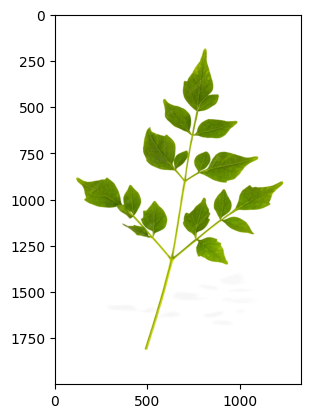

In [24]:
im = imread("data\example_2.jpg")[0]

# Convert the image to 3 channels (RGB)
rgb_image = im[:, :, :3]

# Convert to float: Important for subtraction later which won't work with uint8
image = img_as_float(rgb_image)

# Apply preprocessing operations
image = gaussian_filter(image, 1)
seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image
dilated = reconstruction(seed, mask, method='dilation')
grayscale_dilated = rgb2gray(dilated)
edges1 = canny(grayscale_dilated, sigma=1)
edges_smooth = morphology.dilation(edges1, morphology.disk(5))
edges_smooth = morphology.erosion(edges_smooth, morphology.disk(5))
labels = label(edges_smooth, connectivity=2)
num_leaves = len(np.unique(labels)) - 1

imshow(im)
print("%d - Numer of leaves" % num_leaves)

In [4]:
# Define the folder path containing the images in Google Drive
image_folder_path = '/content/drive/MyDrive/Babyroom_BGR'

##Canny Edge Detection Workflow

In [ ]:
# Create a list to store the leaf counts
leaf_counts = []

# Iterate over each image in the folder
for filename in os.listdir(image_folder_path):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        # Split the filename by "_" and extract the required components
        components = filename.split("_")
        plant_name = components[0]
        date, month, year, time = components[1:5]
        camera_name = components[5].split(".")[0]

        datetime_str = f"{date}_{month}_{year}"

        # Read the image
        image_path = os.path.join(image_folder_path, filename)
        im = imread(image_path)

        # Convert the image to 3 channels (RGB)
        rgb_image = im[:, :, :3]

        # Convert to float: Important for subtraction later which won't work with uint8
        image = img_as_float(rgb_image)

        # Apply preprocessing operations
        image = gaussian_filter(image, 1)
        seed = np.copy(image)
        seed[1:-1, 1:-1] = image.min()
        mask = image
        dilated = reconstruction(seed, mask, method='dilation')
        grayscale_dilated = rgb2gray(dilated)
        edges1 = canny(grayscale_dilated, sigma=1)
        edges_smooth = morphology.dilation(edges1, morphology.disk(5))
        edges_smooth = morphology.erosion(edges_smooth, morphology.disk(5))
        labels = label(edges_smooth, connectivity=2)
        num_leaves = len(np.unique(labels)) - 1

        # Store the leaf count with the plant name, datetime, time, count, and camera name
        leaf_counts.append((plant_name, datetime_str, time, num_leaves, camera_name))

# Sort the leaf counts based on plant name
leaf_counts.sort(key=lambda x: x[0])

# Define the path to the CSV file
csv_file_path = '/content/drive/MyDrive/leaf_counts_babyroom_cany.csv'

# Save the leaf counts in the CSV file
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Plant Name', 'Date_Month_Year', 'Time', 'Leaf Count', 'Camera Name'])
    for plant_name, datetime_str, time, count, camera_name in leaf_counts:
        writer.writerow([plant_name, datetime_str, time, count, camera_name])

print("Sorted leaf counts saved to CSV file.")

Sorted leaf counts saved to CSV file.


##Region Growing Workflow

In [ ]:
import os
import csv
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import peak_local_max
from skimage.filters import sobel
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from datetime import datetime

In [ ]:
# Path to the folder containing the image files
folder_path = '/content/drive/MyDrive/Babyroom_BGR'

# Create a new CSV file to store the results
csv_file = 'leaf_count_results_markers_babyroom.csv'
# Create the CSV file and write the header row
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Plant', 'Date_Month_Year', 'Time', 'Leaf Count'])

# Iterate through each file in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image file
    if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
        # Extract plant name, date, month, year, time from the filename
        parts = filename.split('_')
        plant_name = parts[0]
        date = parts[1]
        month = parts[2]
        year = parts[3]
        time = parts[4][:2]  # Extract the first two characters for the hour

        # Read the image file
        image_path = os.path.join(folder_path, filename)
        image = imread(image_path)

        # Perform the operations on the image
        rgb_image = image[:, :, :3]
        im_ = gaussian(rgb_image, sigma=1)
        br = sobel(im_[:,:,0])
        bg = sobel(im_[:,:,1])
        bb = sobel(im_[:,:,2])
        brgb = br + bg + bb
        markers = peak_local_max(brgb.max() - brgb, threshold_rel=0.99, min_distance=40)
        gray_image = rgb2gray(rgb_image)
        threshold = threshold_otsu(gray_image)
        binary_mask = gray_image > threshold
        foreground_markers = peak_local_max(brgb.max() - brgb, threshold_rel=0.992, min_distance=40, labels=binary_mask)
        foreground_marker_count = len(foreground_markers)

        # Perform leaf counting and store the count in a variable
        leaf_count = foreground_marker_count  # Replace with your leaf counting logic

        # Get the current date and time
        now = datetime.now()
        current_date = now.strftime('%d_%m_%Y')
        current_time = now.strftime('%H:%M:%S')

        # Append the results to the CSV file
        with open(csv_file, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([plant_name, f'{date}_{month}_{year}', time, leaf_count])

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
